Beale synthetic function:

GP ERM versus GP dERM (winner)

https://www.sfu.ca/~ssurjano/beale.html

In [1]:
pip install pyGPGO


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 

In [2]:
!pip install -q latextable


In [3]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
rc('text', usetex=False)

from tabulate import tabulate
from texttable import Texttable

import latextable

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [4]:
### Inputs:

obj_func = 'Beale'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'ERM'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [5]:
### Objective function:

if obj_func == 'Beale':

    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb = -4.5
    ub = +4.5

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return  operator * (
                (1.500 - x1_training + x1_training * x2_training)**2 +
                (2.250 - x1_training + x1_training * x2_training**2)**2 +
                (2.625 - x1_training + x1_training * x2_training**3)**2
                )


In [6]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [7]:
### Cumulative Regret Calculator:

def min_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [8]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [9]:
### Surrogate derivatives:

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)

def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE

    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T

        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)

        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.diag(np.dot(dKstar, alpha_Kstar))

        return dm, ds


In [10]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):
    def __init__(self, mode, eps=eps, **params):

        self.params = params
        self.eps = eps

        mode_dict = {
            'ERM': self.ERM
        }

        self.f = mode_dict[mode]

    def ERM(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        #f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        f = (std + self.eps) * (norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx
        #df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df2 = (std + self.eps) * (-gamma * norm.pdf(gamma))
        df = df1 + df2
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

    def d_eval(self, tau, mean, std, ds, dm):

        return self.f(tau, mean, std, ds, dm, **self.params)


In [11]:
n_start_AcqFunc = 20
inverse = -1
n_start = n_start_AcqFunc

maxfunMinimize = 50 * dim # allows for both function and gradient evaluation capping, using the problem's input dimensions


In [12]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

class GPGO_approx(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t ERM exact \t ERM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncApprox = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncApprox)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncExact = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncExact)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t ERM exact \t ERM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncExact = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncExact)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncApprox = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncApprox)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)

        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [14]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-0.74680196  1.98292044]	 6.5970295	 6.5970295	     	     	     	     	    
init	 [-4.49897063 -1.77900685]	 1305.47105896	 6.5970295	     	     	     	     	    
init	 [-3.17919698 -3.66895265]	 28173.77601348	 6.5970295	     	     	     	     	    
init	 [-2.8236581  -1.38995346]	 237.99317641	 6.5970295	     	     	     	     	    
init	 [-0.92909273  0.34935061]	 26.17906318	 6.5970295	     	     	     	     	    
1  	 [ 3.55145997 -3.7346021 ]	 37124.44633658	 6.5970295	 16.8 	 0.79788458 	 0.79788458 	 1.0 	 7.25
2  	 [-4.35760881  3.8649351 ]	 63368.69487742	 6.5970295	 15.9 	 0.79788457 	 0.79788457 	 1.0 	 3.88
3  	 [3.70892528 3.52114998]	 27968.70132697	 6.5970295	 16.6 	 0.79788458 	 0.79788458 	 1.0 	 6.25
4  	 [-0.32271181 -1.15479911]	 21.27524282	 6.5970295	 9.2 	 0.17329799 	 0.7921688 	 0.219 	 1.357
5  	 [-0.85505523 -1.08155766]	 35.99818302	 6.5970295	 17.

In [15]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-0.57604588 -4.26666391]	 2377.84417418	 8.81624267	     	     	     	     	    
init	 [ 0.4469623  -0.58209847]	 8.81624267	 8.81624267	     	     	     	     	    
init	 [-0.71668978 -1.52698661]	 47.37426285	 8.81624267	     	     	     	     	    
init	 [-2.65816229  1.0734387 ]	 9.0886159	 8.81624267	     	     	     	     	    
init	 [-1.80310794 -2.09855452]	 510.22209437	 8.81624267	     	     	     	     	    
1  	 [4.23522282 2.70232516]	 7632.16731959	 8.81624267	 15.6 	 0.79788458 	 0.79788458 	 1.0 	 6.229
2  	 [ 4.48684396 -3.48944119]	 40148.94910841	 8.81624267	 22.8 	 0.79788423 	 0.79788399 	 1.0 	 7.465
3  	 [-4.5  4.5]	 169680.83203125	 8.81624267	 23.2 	 0.79788306 	 0.7978841 	 1.0 	 9.708
4	 [-0.25757752  1.92194623]	 5.12623165	 5.12623165	 14.1 	 0.78659888 	 0.79761508 	 0.986 	 2.421
5  	 [-1.13923124  0.34383063]	 29.46645452	 5.12623165	 14.7 	 0.7

In [16]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [0.45718112 1.8733304 ]	 41.91271474	 41.91271474	     	     	     	     	    
init	 [-1.88185735  0.09744845]	 47.45118839	 41.91271474	     	     	     	     	    
init	 [3.53652259 3.5666378 ]	 27475.81668992	 41.91271474	     	     	     	     	    
init	 [-3.36973221 -2.6348141 ]	 5079.048973	 41.91271474	     	     	     	     	    
init	 [-4.03679517 -0.53271141]	 138.40865241	 41.91271474	     	     	     	     	    
1  	 [ 2.52283288 -1.74272821]	 259.5550934	 41.91271474	 13.6 	 0.79788444 	 0.79788444 	 1.0 	 4.151
2  	 [-3.83738698  3.53153869]	 28235.98177764	 41.91271474	 8.6 	 0.79788424 	 0.79788424 	 1.0 	 2.474
3	 [ 0.0509355  -0.51638971]	 13.50980698	 13.50980698	 9.9 	 0.0122636 	 0.11917484 	 0.103 	 1.794
4  	 [ 4.5 -4.5]	 178131.83203125	 13.50980698	 9.3 	 0.70277086 	 0.7955019 	 0.883 	 2.489
5	 [ 1.3691844  -0.26077551]	 2.51639071	 2.51639071	 4.2 	

In [17]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number =  4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [4.20326855 0.42509024]	 3.84098566	 3.84098566	     	     	     	     	    
init	 [4.25415924 1.93334394]	 1070.65181379	 3.84098566	     	     	     	     	    
init	 [ 1.77955942 -2.55519454]	 1001.35293114	 3.84098566	     	     	     	     	    
init	 [ 4.28647009 -4.4439277 ]	 150069.47442765	 3.84098566	     	     	     	     	    
init	 [-2.22315874 -0.58687621]	 67.08861689	 3.84098566	     	     	     	     	    
1  	 [-0.74901326  3.6420083 ]	 1124.81021485	 3.84098566	 24.9 	 0.79788452 	 0.7978842 	 1.0 	 6.963
2  	 [-4.5        -4.25463831]	 131319.22239332	 3.84098566	 12.3 	 0.79715274 	 0.79788367 	 0.999 	 4.311
3  	 [-4.5         1.99825734]	 963.15572915	 3.84098566	 6.9 	 0.2730069 	 0.79351898 	 0.344 	 2.415
4  	 [0.84099727 0.49794842]	 7.34193991	 3.84098566	 5.0 	 0.00140928 	 0.26789532 	 0.005 	 0.567
5  	 [0.17901908 0.23847659]	 12.18554433	 3.8409

In [18]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.50206146  3.33659076]	 8263.90556807	 0.31139702	     	     	     	     	    
init	 [-2.6395276   3.76749817]	 19560.15202528	 0.31139702	     	     	     	     	    
init	 [-0.1042993   1.00569477]	 14.18657899	 0.31139702	     	     	     	     	    
init	 [2.39317071 0.16576189]	 0.31139702	 0.31139702	     	     	     	     	    
init	 [-1.82879549 -2.81050894]	 2208.98230863	 0.31139702	     	     	     	     	    
1  	 [ 3.80474653 -4.48007209]	 123826.98871543	 0.31139702	 11.2 	 0.79788458 	 0.79788458 	 1.0 	 5.081
2  	 [3.53685865 4.18641792]	 70717.94191088	 0.31139702	 9.2 	 0.79788458 	 0.79788458 	 1.0 	 3.85
3  	 [-4.5        -0.04066601]	 134.46148173	 0.31139702	 27.3 	 0.79594926 	 0.79787598 	 0.998 	 5.684
4  	 [ 4.5        -0.11607947]	 20.74239111	 0.31139702	 12.2 	 0.79473618 	 0.79780747 	 0.996 	 5.307
5  	 [ 1.27664387 -1.1344632 ]	 8.61194504	 0.

In [19]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 3.53574136 -1.51218175]	 273.31220308	 10.03800071	     	     	     	     	    
init	 [ 2.89106211 -4.12473037]	 43803.25040669	 10.03800071	     	     	     	     	    
init	 [-3.53108988  0.85546858]	 29.82843375	 10.03800071	     	     	     	     	    
init	 [ 0.26835626 -0.73073314]	 10.6589253	 10.03800071	     	     	     	     	    
init	 [-1.48132936  1.10267489]	 10.03800071	 10.03800071	     	     	     	     	    
1  	 [4.28897718 3.03217734]	 15404.22494396	 10.03800071	 19.6 	 0.79788458 	 0.79788458 	 1.0 	 6.318
2  	 [-4.48219217 -4.5       ]	 180424.61128738	 10.03800071	 27.0 	 0.79788379 	 0.79788458 	 1.0 	 12.951
3  	 [-4.5  4.5]	 169680.83203125	 10.03800071	 15.0 	 0.79788233 	 0.79788384 	 1.0 	 9.606
4  	 [0.25893158 4.5       ]	 732.11145619	 10.03800071	 14.2 	 0.3297831 	 0.79337441 	 0.416 	 3.927
5  	 [-1.66597122 -0.90537033]	 58.90488827	 10.03

In [20]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.8132254   2.51926913]	 3321.1422835	 2.96769239	     	     	     	     	    
init	 [-0.55431692  2.0111866 ]	 2.96769239	 2.96769239	     	     	     	     	    
init	 [4.30190561 0.34646283]	 6.32173172	 2.96769239	     	     	     	     	    
init	 [ 0.01008417 -3.8515398 ]	 11.97189446	 2.96769239	     	     	     	     	    
init	 [-2.08404918e+00 -1.05749257e-03]	 53.82031719	 2.96769239	     	     	     	     	    
1  	 [2.83892308 4.5       ]	 70181.74581425	 2.96769239	 32.7 	 0.79788454 	 0.79788457 	 1.0 	 6.843
2  	 [ 4.39854243 -4.5       ]	 170149.63864005	 2.96769239	 21.2 	 0.79743627 	 0.79788456 	 0.999 	 8.061
3  	 [-4.09710365 -4.42605145]	 137045.78243033	 2.96769239	 16.6 	 0.7978845 	 0.7978845 	 1.0 	 5.682
4  	 [-3.5381093  -1.17462676]	 226.89781538	 2.96769239	 3.0 	 0.79788458 	 0.79788458 	 1.0 	 0.0
5  	 [ 1.14124938 -0.30950292]	 3.58598636	 2.

In [21]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [3.36086463 4.21686597]	 66731.07602387	 1.86933486	     	     	     	     	    
init	 [3.32275086 0.27770122]	 1.86933486	 1.86933486	     	     	     	     	    
init	 [-2.40544505 -4.39741076]	 45883.36172615	 1.86933486	     	     	     	     	    
init	 [-0.62578064 -0.87883776]	 26.39306085	 1.86933486	     	     	     	     	    
init	 [ 0.20407204 -0.19447384]	 11.649231	 1.86933486	     	     	     	     	    
1  	 [ 4.36274494 -4.24141156]	 118259.86417502	 1.86933486	 16.0 	 0.79788457 	 0.79788457 	 1.0 	 5.366
2  	 [-4.5  4.5]	 169680.83203125	 1.86933486	 15.6 	 0.79788458 	 0.79788458 	 1.0 	 6.815
3	 [ 2.07599151 -0.15217057]	 1.13823032	 1.13823032	 18.4 	 0.48847697 	 0.77715228 	 0.629 	 2.554
4  	 [ 2.41785992 -0.09761311]	 1.39438068	 1.13823032	 13.0 	 0.15356215 	 0.67582615 	 0.227 	 2.8
5  	 [-4.5        -0.36317012]	 150.06793713	 1.13823032	 6.2 	 0.3

In [22]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-4.40663262  0.01687133]	 127.75319006	 22.47920466	     	     	     	     	    
init	 [-0.03804036 -3.29553424]	 22.47920466	 22.47920466	     	     	     	     	    
init	 [-3.22100023 -2.53297192]	 3783.05384026	 22.47920466	     	     	     	     	    
init	 [-0.73342638 -2.26708948]	 157.51337782	 22.47920466	     	     	     	     	    
init	 [-3.74346314 -1.39051224]	 380.77306777	 22.47920466	     	     	     	     	    
1  	 [2.73365793 4.35023323]	 53339.37070055	 22.47920466	 13.2 	 0.79788458 	 0.79788458 	 1.0 	 3.486
2  	 [-2.92392605  4.01875275]	 35761.2089455	 22.47920466	 15.3 	 0.79788458 	 0.79788458 	 1.0 	 4.719
3  	 [ 3.47248444 -3.77789856]	 37940.05899533	 22.47920466	 13.5 	 0.79788458 	 0.79788458 	 1.0 	 3.154
4	 [1.37945108 0.43201456]	 3.62659058	 3.62659058	 7.6 	 0.79788441 	 0.79788442 	 1.0 	 2.76
5  	 [4.5       0.0725347]	 15.61381155	 3.626

In [23]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 2.44188579 -4.31323246]	 40500.70899506	 15.22952398	     	     	     	     	    
init	 [1.20283411 2.23923494]	 281.87686993	 15.22952398	     	     	     	     	    
init	 [-0.01343689 -2.47683019]	 15.22952398	 15.22952398	     	     	     	     	    
init	 [-2.71743422  2.34477641]	 985.56374709	 15.22952398	     	     	     	     	    
init	 [-2.97800247 -3.70494167]	 26177.14611647	 15.22952398	     	     	     	     	    
1	 [4.20744939 0.00961167]	 13.44715649	 13.44715649	 8.8 	 0.79788456 	 0.79788381 	 1.0 	 2.091
2  	 [-0.35561398 -0.56339135]	 19.70792924	 13.44715649	 22.0 	 0.79788456 	 0.79721794 	 1.001 	 5.374
3  	 [4.09756138 4.5       ]	 145155.50343135	 13.44715649	 21.2 	 0.79788454 	 0.7978836 	 1.0 	 7.558
4  	 [ 2.78902499 -0.86877144]	 20.2031656	 13.44715649	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
5  	 [-4.5        -0.10613784]	 137.68259691	 13.44715649	 

In [24]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.8775728  -4.32472283]	 59421.148191	 2.8907295	     	     	     	     	    
init	 [-0.33103326  2.02440536]	 2.8907295	 2.8907295	     	     	     	     	    
init	 [-0.71816756 -0.13115612]	 25.27144735	 2.8907295	     	     	     	     	    
init	 [-4.38497267 -0.11365553]	 133.25157969	 2.8907295	     	     	     	     	    
init	 [3.97625987 3.1571558 ]	 16859.81677191	 2.8907295	     	     	     	     	    
1  	 [ 3.85319338 -3.08262202]	 14446.94750794	 2.8907295	 17.2 	 0.79788454 	 0.79788458 	 1.0 	 8.992
2  	 [-4.5       3.343893]	 27943.04965691	 2.8907295	 26.0 	 0.79782442 	 0.79788401 	 1.0 	 8.167
3  	 [0.98822214 0.12202535]	 4.71424326	 2.8907295	 6.0 	 0.03092815 	 0.06245027 	 0.495 	 0.797
4  	 [-0.20688852  2.37404978]	 3.14830842	 2.8907295	 6.6 	 2.169e-05 	 0.26096321 	 0.0 	 1.866
5  	 [-0.16950315  4.5       ]	 161.90794312	 2.8907295	 8.2 	 0.1886

In [25]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.11253442  2.16044727]	 746.34127209	 48.45196617	     	     	     	     	    
init	 [-2.13016486  0.30365454]	 48.45196617	 48.45196617	     	     	     	     	    
init	 [-4.36882534  3.76872307]	 54651.23560734	 48.45196617	     	     	     	     	    
init	 [ 3.60643369 -4.19920715]	 76007.68460601	 48.45196617	     	     	     	     	    
init	 [ 4.11254403 -3.26511611]	 22941.17826205	 48.45196617	     	     	     	     	    
1  	 [4.05282172 2.40728086]	 3559.14829857	 48.45196617	 15.0 	 0.79788458 	 0.79788458 	 1.0 	 5.072
2  	 [-4.5 -4.5]	 181853.61328125	 48.45196617	 12.2 	 0.79772866 	 0.79788458 	 1.0 	 6.462
3  	 [0.39282521 2.5058157 ]	 93.84807352	 48.45196617	 5.8 	 0.58965815 	 0.79788289 	 0.739 	 0.875
4	 [-0.89015585  0.80208785]	 18.73952721	 18.73952721	 11.4 	 0.75351188 	 0.78007686 	 0.966 	 1.021
5  	 [-0.3089495  -1.89738069]	 33.27448295	 18.73

In [26]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 2.4993217  -2.36212902]	 1312.05970237	 25.91775807	     	     	     	     	    
init	 [2.91850679 4.19174278]	 48757.43948599	 25.91775807	     	     	     	     	    
init	 [ 4.25341003 -0.41895677]	 25.91775807	 25.91775807	     	     	     	     	    
init	 [0.98138216 2.47973863]	 337.87505127	 25.91775807	     	     	     	     	    
init	 [1.2745201  1.99816407]	 177.13741609	 25.91775807	     	     	     	     	    
1  	 [-3.61122103 -2.28996805]	 2810.33458081	 25.91775807	 11.4 	 0.79788458 	 0.79788458 	 1.0 	 2.592
2  	 [-3.33937733  2.34510909]	 1548.84665691	 25.91775807	 10.6 	 0.79788439 	 0.79788438 	 1.0 	 2.784
3  	 [-0.4781407 -4.5      ]	 2243.8514097	 25.91775807	 5.0 	 0.10198255 	 0.79274353 	 0.129 	 1.61
4	 [-0.28126939  0.09971579]	 17.91174361	 17.91174361	 9.3 	 0.51906565 	 0.79784023 	 0.651 	 1.902
5	 [4.5        0.63848619]	 0.6839271	 0.68392

In [27]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [0.12549009 2.45848547]	 30.19066755	 11.36701553	     	     	     	     	    
init	 [ 3.33384917 -4.42757746]	 88548.39506592	 11.36701553	     	     	     	     	    
init	 [-1.71237667  4.11843365]	 13933.41432038	 11.36701553	     	     	     	     	    
init	 [ 0.11805041 -1.63544018]	 11.36701553	 11.36701553	     	     	     	     	    
init	 [ 0.35279944 -2.50870552]	 27.90050047	 11.36701553	     	     	     	     	    
1  	 [-4.03543301 -1.65672896]	 797.8457655	 11.36701553	 14.0 	 0.79788458 	 0.79788458 	 1.0 	 3.378
2  	 [4.5        1.26098642]	 82.3072389	 11.36701553	 15.3 	 0.79788458 	 0.79788458 	 1.0 	 7.747
3  	 [3.27002404 4.32260185]	 73176.87228242	 11.36701553	 35.8 	 0.79788444 	 0.79788376 	 1.0 	 6.06
4	 [1.5847787 0.449913 ]	 2.77006312	 2.77006312	 28.0 	 0.79784714 	 0.79787794 	 1.0 	 4.635
5  	 [-0.97166101  0.44344552]	 25.68292825	 2.77006312	

In [28]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 3.13935928 -2.88993668]	 6575.87582121	 47.08268654	     	     	     	     	    
init	 [-4.01073107 -1.24615399]	 317.71090829	 47.08268654	     	     	     	     	    
init	 [-2.02139164  0.27000202]	 47.08268654	 47.08268654	     	     	     	     	    
init	 [-1.74672976 -1.75973077]	 234.87929684	 47.08268654	     	     	     	     	    
init	 [-3.49432851 -2.25090888]	 2421.67103335	 47.08268654	     	     	     	     	    
1  	 [2.43932502 2.62619551]	 2275.13136959	 47.08268654	 19.8 	 0.79788458 	 0.79788458 	 1.0 	 5.544
2  	 [-4.36496259  3.59754668]	 41096.95302957	 47.08268654	 9.9 	 0.79788458 	 0.79788458 	 1.0 	 2.524
3  	 [-0.30579306 -4.5       ]	 971.75352671	 47.08268654	 13.4 	 0.78911278 	 0.79781199 	 0.989 	 3.089
4  	 [-0.50266133  4.5       ]	 1876.5725786	 47.08268654	 9.0 	 0.7793694 	 0.79771994 	 0.977 	 1.698
5	 [ 0.01260227 -0.31803124]	 14.0346

In [29]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.49038029  0.20847007]	 59.44289418	 59.44289418	     	     	     	     	    
init	 [ 0.45631311 -4.08958245]	 932.93744896	 59.44289418	     	     	     	     	    
init	 [-1.25344048 -2.49227152]	 594.94949578	 59.44289418	     	     	     	     	    
init	 [ 1.69853546 -3.02641717]	 2418.38944042	 59.44289418	     	     	     	     	    
init	 [-3.8670762   3.96909774]	 58473.38862292	 59.44289418	     	     	     	     	    
1  	 [1.88327549 4.24840973]	 22307.11133709	 59.44289418	 7.6 	 0.79788456 	 0.79788423 	 1.0 	 2.567
2	 [4.5        0.20087533]	 12.05201226	 12.05201226	 4.8 	 0.7897306 	 0.79275991 	 0.996 	 1.504
3	 [ 1.13760564 -0.03938479]	 3.55434889	 3.55434889	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
4  	 [-4.5 -4.5]	 181853.61328125	 3.55434889	 11.0 	 0.41256632 	 0.79414204 	 0.52 	 2.997
5  	 [0.39492363 0.36193321]	 10.25056095	 3.55434889	 4.2 	 0.33186772 	

In [30]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-1.84801498  0.2752808 ]	 43.39160389	 6.89162337	     	     	     	     	    
init	 [-2.77631292 -3.88889678]	 30048.58268622	 6.89162337	     	     	     	     	    
init	 [2.58286914 1.4070017 ]	 81.72560623	 6.89162337	     	     	     	     	    
init	 [1.23768806 0.68042604]	 6.89162337	 6.89162337	     	     	     	     	    
init	 [-4.14843375 -1.27967756]	 359.43439337	 6.89162337	     	     	     	     	    
1  	 [ 4.35945178 -3.9086791 ]	 73232.4143311	 6.89162337	 20.1 	 0.79788458 	 0.79788458 	 1.0 	 7.681
2  	 [-1.01404767  4.46608075]	 7807.3097841	 6.89162337	 17.1 	 0.79788399 	 0.79788391 	 1.0 	 3.858
3  	 [4.5 4.5]	 174813.36328125	 6.89162337	 6.4 	 0.79757154 	 0.79757154 	 1.0 	 1.466
4	 [3.03414853 0.14010923]	 1.91563027	 1.91563027	 15.2 	 0.72798318 	 0.78002724 	 0.933 	 1.35
5	 [ 1.95892872 -0.04531586]	 0.83046308	 0.83046308	 13.0 	 0.69086855 	

In [31]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [1.35336818 0.04908036]	 2.47265265	 2.47265265	     	     	     	     	    
init	 [ 3.40741324 -2.86343797]	 7379.01731459	 2.47265265	     	     	     	     	    
init	 [3.17009762 2.25122657]	 1528.31014198	 2.47265265	     	     	     	     	    
init	 [1.49491501 4.39105903]	 17224.91329528	 2.47265265	     	     	     	     	    
init	 [-2.1872842  -4.24524667]	 31030.3482424	 2.47265265	     	     	     	     	    
1  	 [-4.40084975  2.56412479]	 5036.76090595	 2.47265265	 6.3 	 0.79788458 	 0.79788458 	 1.0 	 1.236
2  	 [-0.84163754  0.25733627]	 25.65089836	 2.47265265	 15.2 	 0.79683287 	 0.79710795 	 1.0 	 1.279
3  	 [ 0.6720197 -0.115564 ]	 6.89148721	 2.47265265	 5.1 	 0.51249194 	 0.57613368 	 0.89 	 0.838
4  	 [-1.60849993 -0.12166083]	 43.56959757	 2.47265265	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
5  	 [-0.05787514  0.37788318]	 14.82859343	 2.47265265	 3.0 	 1.4e-07 

In [32]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.62219758  2.35124745]	 1879.40901857	 63.54408607	     	     	     	     	    
init	 [-2.27755824 -3.25681481]	 7496.2434103	 63.54408607	     	     	     	     	    
init	 [-1.51698093 -3.75300391]	 7497.40754262	 63.54408607	     	     	     	     	    
init	 [1.54779373 2.75934418]	 1302.43419574	 63.54408607	     	     	     	     	    
init	 [4.34467723 1.22094661]	 63.54408607	 63.54408607	     	     	     	     	    
1  	 [ 4.5 -4.5]	 178131.83203125	 63.54408607	 10.0 	 0.79788439 	 0.79788458 	 1.0 	 7.372
2  	 [4.5 4.5]	 174813.36328125	 63.54408607	 3.3 	 0.49140031 	 0.49140031 	 1.0 	 0.396
3	 [0.22919318 0.51697962]	 12.15776069	 12.15776069	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
4	 [ 1.40092954 -0.68295956]	 3.59817063	 3.59817063	 9.8 	 0.21167582 	 0.64425716 	 0.329 	 2.342
5	 [2.73319548 0.64801896]	 1.13498158	 1.13498158	 8.1 	 0.78627619 	 0.7892814 	 0.996 

In [33]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [0.79317721 3.57942355]	 1607.3829987	 30.55204393	     	     	     	     	    
init	 [3.52377657 2.8425373 ]	 7209.15006059	 30.55204393	     	     	     	     	    
init	 [-4.17699373  1.72581824]	 253.68900137	 30.55204393	     	     	     	     	    
init	 [-1.09187152  0.16659851]	 30.55204393	 30.55204393	     	     	     	     	    
init	 [ 1.42156319 -2.75534804]	 963.93628383	 30.55204393	     	     	     	     	    
1	 [0.122115   0.01132059]	 12.69477394	 12.69477394	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
2  	 [-4.18016676 -3.40700607]	 31793.97698066	 12.69477394	 6.4 	 0.79788455 	 0.79788455 	 1.0 	 3.026
3  	 [-2.05277526  4.11642488]	 20137.75885436	 12.69477394	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
4  	 [ 4.06603407 -2.50992755]	 5050.28462291	 12.69477394	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
5  	 [-1.02146841 -0.9112768 ]	 37.32205199	 12.69477394	 3.0 	 1e-08 	 1e-08 	 1.0 

In [34]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-0.74680196  1.98292044]	 6.5970295	 6.5970295	     	     	     	     	    
init	 [-4.49897063 -1.77900685]	 1305.47105896	 6.5970295	     	     	     	     	    
init	 [-3.17919698 -3.66895265]	 28173.77601348	 6.5970295	     	     	     	     	    
init	 [-2.8236581  -1.38995346]	 237.99317641	 6.5970295	     	     	     	     	    
init	 [-0.92909273  0.34935061]	 26.17906318	 6.5970295	     	     	     	     	    
1  	 [ 3.55145997 -3.7346021 ]	 37124.44633658	 6.5970295	 20.0 	 0.79788458 	 0.79788458 	 1.0 	 6.647
2  	 [-4.35760881  3.8649351 ]	 63368.6949046	 6.5970295	 13.4 	 0.79788457 	 0.79788457 	 1.0 	 6.034
3  	 [3.17106043 4.25091958]	 62386.9143349	 6.5970295	 10.9 	 0.79788458 	 0.79788458 	 1.0 	 6.661
4	 [0.95546289 0.46259983]	 6.33239797	 6.33239797	 5.6 	 0.22881602 	 0.79180205 	 0.289 	 0.024
5  	 [-0.49147149 -1.24166441]	 27.16589306	 6.33239797	 4.2 

In [35]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-0.57604588 -4.26666391]	 2377.84417418	 8.81624267	     	     	     	     	    
init	 [ 0.4469623  -0.58209847]	 8.81624267	 8.81624267	     	     	     	     	    
init	 [-0.71668978 -1.52698661]	 47.37426285	 8.81624267	     	     	     	     	    
init	 [-2.65816229  1.0734387 ]	 9.0886159	 8.81624267	     	     	     	     	    
init	 [-1.80310794 -2.09855452]	 510.22209437	 8.81624267	     	     	     	     	    
1  	 [2.30231332 4.5       ]	 46410.90820276	 8.81624267	 19.0 	 0.79788458 	 0.79788458 	 1.0 	 8.304
2  	 [ 4.5        -3.20330735]	 24669.35929599	 8.81624267	 23.5 	 0.79788426 	 0.7978841 	 1.0 	 3.41
3  	 [-2.69603085  3.68208312]	 17741.67807641	 8.81624267	 22.3 	 0.79382097 	 0.7978841 	 0.995 	 1.653
4	 [4.05096982 0.85032334]	 3.20473415	 3.20473415	 6.6 	 0.77632712 	 0.79745936 	 0.974 	 0.308
5  	 [0.12961854 0.98037134]	 14.13361639	 3.20473415	 3

In [36]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [0.45718112 1.8733304 ]	 41.91271474	 41.91271474	     	     	     	     	    
init	 [-1.88185735  0.09744845]	 47.45118839	 41.91271474	     	     	     	     	    
init	 [3.53652259 3.5666378 ]	 27475.81668992	 41.91271474	     	     	     	     	    
init	 [-3.36973221 -2.6348141 ]	 5079.048973	 41.91271474	     	     	     	     	    
init	 [-4.03679517 -0.53271141]	 138.40865241	 41.91271474	     	     	     	     	    
1  	 [ 2.52283288 -1.74272821]	 259.55509337	 41.91271474	 13.1 	 0.79788444 	 0.79788444 	 1.0 	 1.752
2  	 [-3.83738698  3.53153869]	 28235.98178143	 41.91271474	 7.0 	 0.79788424 	 0.79788424 	 1.0 	 1.854
3	 [ 0.10527333 -1.65375217]	 11.58393745	 11.58393745	 4.0 	 0.01226863 	 0.11916899 	 0.103 	 0.57
4  	 [ 0.34913392 -3.81990236]	 344.27143406	 11.58393745	 6.6 	 0.66975228 	 0.79549534 	 0.842 	 0.597
5  	 [-0.10851648  0.10274881]	 15.58024589	 1

In [37]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [4.20326855 0.42509024]	 3.84098566	 3.84098566	     	     	     	     	    
init	 [4.25415924 1.93334394]	 1070.65181379	 3.84098566	     	     	     	     	    
init	 [ 1.77955942 -2.55519454]	 1001.35293114	 3.84098566	     	     	     	     	    
init	 [ 4.28647009 -4.4439277 ]	 150069.47442765	 3.84098566	     	     	     	     	    
init	 [-2.22315874 -0.58687621]	 67.08861689	 3.84098566	     	     	     	     	    
1  	 [-1.16594447  3.92272739]	 4648.57661236	 3.84098566	 21.6 	 0.79788452 	 0.7978842 	 1.0 	 5.57
2  	 [-4.06319277 -3.51163694]	 35668.81576719	 3.84098566	 5.6 	 0.79715331 	 0.79788367 	 0.999 	 0.147
3	 [-3.60605012  1.18523021]	 1.36856037	 1.36856037	 3.2 	 0.11737195 	 0.76609984 	 0.153 	 0.444
4  	 [0.43924606 0.89817742]	 13.0756295	 1.36856037	 2.0 	 0.00143186 	 0.34389141 	 0.004 	 0.0
5  	 [-4.16029338  1.28977669]	 4.93082256	 1.36856037	 6

In [38]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.50206146  3.33659076]	 8263.90556807	 0.31139702	     	     	     	     	    
init	 [-2.6395276   3.76749817]	 19560.15202528	 0.31139702	     	     	     	     	    
init	 [-0.1042993   1.00569477]	 14.18657899	 0.31139702	     	     	     	     	    
init	 [2.39317071 0.16576189]	 0.31139702	 0.31139702	     	     	     	     	    
init	 [-1.82879549 -2.81050894]	 2208.98230863	 0.31139702	     	     	     	     	    
1  	 [ 3.80474653 -4.48007209]	 123826.98871543	 0.31139702	 10.6 	 0.79788458 	 0.79788458 	 1.0 	 5.625
2  	 [4.5 4.5]	 174813.36328125	 0.31139702	 5.8 	 0.79788458 	 0.79788458 	 1.0 	 8.056
3  	 [4.18695629 0.32590908]	 5.9834036	 0.31139702	 18.2 	 0.79707465 	 0.797876 	 0.999 	 2.618
4  	 [ 1.44896968 -1.2093832 ]	 13.34642575	 0.31139702	 13.0 	 0.79498237 	 0.79591112 	 0.999 	 2.144
5  	 [1.44646481 1.97131677]	 200.00977486	 0.31139702	 9.8 	 0.7

In [39]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 3.53574136 -1.51218175]	 273.31220308	 10.03800071	     	     	     	     	    
init	 [ 2.89106211 -4.12473037]	 43803.25040669	 10.03800071	     	     	     	     	    
init	 [-3.53108988  0.85546858]	 29.82843375	 10.03800071	     	     	     	     	    
init	 [ 0.26835626 -0.73073314]	 10.6589253	 10.03800071	     	     	     	     	    
init	 [-1.48132936  1.10267489]	 10.03800071	 10.03800071	     	     	     	     	    
1  	 [4.28897718 3.03217734]	 15404.22494396	 10.03800071	 14.6 	 0.79788458 	 0.79788458 	 1.0 	 6.285
2  	 [-2.23547271 -4.12762049]	 27562.53354524	 10.03800071	 20.3 	 0.79788379 	 0.79788458 	 1.0 	 5.755
3  	 [-2.60967575  4.5       ]	 56450.70478669	 10.03800071	 9.3 	 0.7978823 	 0.79788322 	 1.0 	 3.468
4  	 [-1.48801309  0.73767282]	 24.50849996	 10.03800071	 4.7 	 0.31573427 	 0.76063938 	 0.415 	 1.498
5  	 [0.78406116 1.19636226]	 19.5688648

In [40]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.8132254   2.51926913]	 3321.1422835	 2.96769239	     	     	     	     	    
init	 [-0.55431692  2.0111866 ]	 2.96769239	 2.96769239	     	     	     	     	    
init	 [4.30190561 0.34646283]	 6.32173172	 2.96769239	     	     	     	     	    
init	 [ 0.01008417 -3.8515398 ]	 11.97189446	 2.96769239	     	     	     	     	    
init	 [-2.08404918e+00 -1.05749257e-03]	 53.82031719	 2.96769239	     	     	     	     	    
1  	 [4.5 4.5]	 174813.36328125	 2.96769239	 20.6 	 0.79788454 	 0.79788457 	 1.0 	 5.366
2  	 [ 2.59922914 -2.14093054]	 827.41962963	 2.96769239	 12.2 	 0.79786671 	 0.79788457 	 1.0 	 2.266
3  	 [-4.09710365 -4.42605145]	 137045.78243033	 2.96769239	 10.6 	 0.79788449 	 0.79788449 	 1.0 	 0.729
4  	 [-3.5381093  -1.17462676]	 226.89781538	 2.96769239	 1.6 	 0.79788458 	 0.79788458 	 1.0 	 0.0
5  	 [-0.1139251   3.82598609]	 15.13310886	 2.96769239	 3.9 	

In [41]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [3.36086463 4.21686597]	 66731.07602387	 1.86933486	     	     	     	     	    
init	 [3.32275086 0.27770122]	 1.86933486	 1.86933486	     	     	     	     	    
init	 [-2.40544505 -4.39741076]	 45883.36172615	 1.86933486	     	     	     	     	    
init	 [-0.62578064 -0.87883776]	 26.39306085	 1.86933486	     	     	     	     	    
init	 [ 0.20407204 -0.19447384]	 11.649231	 1.86933486	     	     	     	     	    
1  	 [ 4.36274494 -4.24141156]	 118259.86423458	 1.86933486	 17.7 	 0.79788457 	 0.79788457 	 1.0 	 3.724
2  	 [-4.42522463  2.59724938]	 5535.69526567	 1.86933486	 14.6 	 0.79788458 	 0.79788458 	 1.0 	 2.81
3  	 [-0.31839138  1.43299674]	 9.54701569	 1.86933486	 8.0 	 0.41346162 	 0.77773564 	 0.532 	 1.374
4  	 [0.90052539 0.4233916 ]	 6.45890918	 1.86933486	 5.6 	 0.0214903 	 0.7782736 	 0.028 	 1.482
5  	 [-0.90749151  0.39981549]	 25.32745673	 1.86933486	 2

In [42]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number =  9

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-4.40663262  0.01687133]	 127.75319006	 22.47920466	     	     	     	     	    
init	 [-0.03804036 -3.29553424]	 22.47920466	 22.47920466	     	     	     	     	    
init	 [-3.22100023 -2.53297192]	 3783.05384026	 22.47920466	     	     	     	     	    
init	 [-0.73342638 -2.26708948]	 157.51337782	 22.47920466	     	     	     	     	    
init	 [-3.74346314 -1.39051224]	 380.77306777	 22.47920466	     	     	     	     	    
1  	 [2.73365793 4.35023323]	 53339.37070055	 22.47920466	 9.0 	 0.79788458 	 0.79788458 	 1.0 	 3.982
2  	 [-1.77632422  4.23718376]	 17884.71913288	 22.47920466	 13.2 	 0.79788458 	 0.79788458 	 1.0 	 3.093
3  	 [ 3.47248444 -3.77789856]	 37940.05899533	 22.47920466	 14.2 	 0.79788458 	 0.79788458 	 1.0 	 1.798
4	 [0.68523918 0.72091363]	 10.22728376	 10.22728376	 6.8 	 0.79788424 	 0.79788442 	 1.0 	 2.513
5	 [4.5        0.31909561]	 8.64558204	 8.6

In [43]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 2.44188579 -4.31323246]	 40500.70899506	 15.22952398	     	     	     	     	    
init	 [1.20283411 2.23923494]	 281.87686993	 15.22952398	     	     	     	     	    
init	 [-0.01343689 -2.47683019]	 15.22952398	 15.22952398	     	     	     	     	    
init	 [-2.71743422  2.34477641]	 985.56374709	 15.22952398	     	     	     	     	    
init	 [-2.97800247 -3.70494167]	 26177.14611647	 15.22952398	     	     	     	     	    
1  	 [4.5 4.5]	 174813.36328125	 15.22952398	 4.1 	 0.79788456 	 0.79788381 	 1.0 	 1.556
2  	 [ 4.5        -0.26763461]	 25.23909335	 15.22952398	 11.6 	 0.79785997 	 0.7978601 	 1.0 	 1.492
3	 [ 0.51565866 -1.0339776 ]	 7.79717105	 7.79717105	 9.1 	 0.75625401 	 0.79776639 	 0.948 	 0.357
4  	 [-1.44338796  4.46156881]	 16044.69937164	 7.79717105	 15.6 	 0.79788457 	 0.79788458 	 1.0 	 5.158
5  	 [-4.41701008  0.39118535]	 99.37796826	 7.79717105	 1

In [44]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.8775728  -4.32472283]	 59421.148191	 2.8907295	     	     	     	     	    
init	 [-0.33103326  2.02440536]	 2.8907295	 2.8907295	     	     	     	     	    
init	 [-0.71816756 -0.13115612]	 25.27144735	 2.8907295	     	     	     	     	    
init	 [-4.38497267 -0.11365553]	 133.25157969	 2.8907295	     	     	     	     	    
init	 [3.97625987 3.1571558 ]	 16859.81677191	 2.8907295	     	     	     	     	    
1  	 [ 3.02685611 -3.5678878 ]	 20587.50826369	 2.8907295	 12.8 	 0.79788454 	 0.79788458 	 1.0 	 4.151
2  	 [-2.54338498  2.62814242]	 1851.27574787	 2.8907295	 18.2 	 0.79782442 	 0.79788401 	 1.0 	 5.149
3  	 [ 4.5        -0.60236532]	 41.16364859	 2.8907295	 13.0 	 0.79788457 	 0.79788457 	 1.0 	 3.337
4  	 [0.72364482 0.68695683]	 9.6728566	 2.8907295	 2.2 	 0.79213922 	 0.79516874 	 0.996 	 0.297
5  	 [-0.02802103  1.28696339]	 13.9311925	 2.8907295	 5.6 	 0.7

In [45]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.11253442  2.16044727]	 746.34127209	 48.45196617	     	     	     	     	    
init	 [-2.13016486  0.30365454]	 48.45196617	 48.45196617	     	     	     	     	    
init	 [-4.36882534  3.76872307]	 54651.23560734	 48.45196617	     	     	     	     	    
init	 [ 3.60643369 -4.19920715]	 76007.68460601	 48.45196617	     	     	     	     	    
init	 [ 4.11254403 -3.26511611]	 22941.17826205	 48.45196617	     	     	     	     	    
1  	 [4.05282172 2.40728086]	 3559.14830712	 48.45196617	 10.9 	 0.79788458 	 0.79788458 	 1.0 	 5.119
2  	 [-1.68944403 -3.87113693]	 11021.46952008	 48.45196617	 5.4 	 0.79772866 	 0.79788458 	 1.0 	 0.0
3	 [1.29773841 0.05133721]	 2.74771566	 2.74771566	 3.4 	 0.26041496 	 0.79788289 	 0.326 	 1.276
4  	 [0.27902734 4.0138031 ]	 463.01339553	 2.74771566	 5.0 	 0.79505771 	 0.7978845 	 0.996 	 1.226
5  	 [1.44661916 1.02091603]	 15.06890154	 2.7

In [46]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 2.4993217  -2.36212902]	 1312.05970237	 25.91775807	     	     	     	     	    
init	 [2.91850679 4.19174278]	 48757.43948599	 25.91775807	     	     	     	     	    
init	 [ 4.25341003 -0.41895677]	 25.91775807	 25.91775807	     	     	     	     	    
init	 [0.98138216 2.47973863]	 337.87505127	 25.91775807	     	     	     	     	    
init	 [1.2745201  1.99816407]	 177.13741609	 25.91775807	     	     	     	     	    
1  	 [-3.61122103 -2.28996805]	 2810.33458081	 25.91775807	 8.0 	 0.79788458 	 0.79788458 	 1.0 	 0.75
2  	 [-3.33882507  2.34566135]	 1550.781833	 25.91775807	 6.3 	 0.79788439 	 0.79788438 	 1.0 	 0.685
3  	 [ 0.57213155 -4.41139103]	 2381.62231166	 25.91775807	 2.4 	 0.10198685 	 0.79274372 	 0.129 	 0.0
4	 [1.74291706 0.54254719]	 2.88103789	 2.88103789	 3.7 	 0.77560352 	 0.79786395 	 0.972 	 1.031
5	 [3.59971885 0.59140491]	 0.06202869	 0.06202869	 1

In [47]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [0.12549009 2.45848547]	 30.19066755	 11.36701553	     	     	     	     	    
init	 [ 3.33384917 -4.42757746]	 88548.39506592	 11.36701553	     	     	     	     	    
init	 [-1.71237667  4.11843365]	 13933.41432038	 11.36701553	     	     	     	     	    
init	 [ 0.11805041 -1.63544018]	 11.36701553	 11.36701553	     	     	     	     	    
init	 [ 0.35279944 -2.50870552]	 27.90050047	 11.36701553	     	     	     	     	    
1  	 [-4.03543301 -1.65672896]	 797.8457655	 11.36701553	 12.6 	 0.79788458 	 0.79788458 	 1.0 	 2.839
2  	 [4.5 4.5]	 174813.36328125	 11.36701553	 14.0 	 0.79788458 	 0.79788458 	 1.0 	 12.855
3  	 [ 4.0827375  -0.01405821]	 12.45130623	 11.36701553	 16.5 	 0.79788397 	 0.79788384 	 1.0 	 5.05
4	 [1.61478659 0.33145619]	 1.97991759	 1.97991759	 14.0 	 0.79772981 	 0.79787269 	 1.0 	 2.199
5  	 [-2.8535921   1.35215239]	 2.74166464	 1.97991759	 21.8 	 

In [48]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 3.13935928 -2.88993668]	 6575.87582121	 47.08268654	     	     	     	     	    
init	 [-4.01073107 -1.24615399]	 317.71090829	 47.08268654	     	     	     	     	    
init	 [-2.02139164  0.27000202]	 47.08268654	 47.08268654	     	     	     	     	    
init	 [-1.74672976 -1.75973077]	 234.87929684	 47.08268654	     	     	     	     	    
init	 [-3.49432851 -2.25090888]	 2421.67103335	 47.08268654	     	     	     	     	    
1  	 [4.5        2.57737831]	 6488.65937561	 47.08268654	 11.0 	 0.79788458 	 0.79788458 	 1.0 	 6.854
2  	 [-4.36496259  3.59754668]	 41096.95302957	 47.08268654	 11.6 	 0.79788458 	 0.79788458 	 1.0 	 2.5
3  	 [0.10743538 3.15445358]	 48.0023128	 47.08268654	 9.8 	 0.79788453 	 0.79788433 	 1.0 	 2.123
4  	 [-0.72199557 -4.31961616]	 3925.92774461	 47.08268654	 8.4 	 0.79624699 	 0.79783385 	 0.998 	 1.641
5	 [1.89359324 0.28487793]	 0.88236845	 0.8

In [49]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.49038029  0.20847007]	 59.44289418	 59.44289418	     	     	     	     	    
init	 [ 0.45631311 -4.08958245]	 932.93744896	 59.44289418	     	     	     	     	    
init	 [-1.25344048 -2.49227152]	 594.94949578	 59.44289418	     	     	     	     	    
init	 [ 1.69853546 -3.02641717]	 2418.38944042	 59.44289418	     	     	     	     	    
init	 [-3.8670762   3.96909774]	 58473.38862292	 59.44289418	     	     	     	     	    
1  	 [2.1185031  4.45133068]	 36954.10583681	 59.44289418	 6.4 	 0.79788456 	 0.79788423 	 1.0 	 4.192
2	 [4.5        0.40073258]	 6.27846828	 6.27846828	 2.4 	 0.78494764 	 0.79154134 	 0.992 	 1.703
3	 [ 1.13760564 -0.03938479]	 3.55434889	 3.55434889	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0
4  	 [-4.36830418 -2.50855981]	 6487.36223482	 3.55434889	 5.8 	 0.41256688 	 0.79414205 	 0.52 	 0.197
5  	 [0.04263394 0.60870705]	 13.86105418	 3.55434889	 4.3 	 0.

In [50]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-1.84801498  0.2752808 ]	 43.39160389	 6.89162337	     	     	     	     	    
init	 [-2.77631292 -3.88889678]	 30048.58268622	 6.89162337	     	     	     	     	    
init	 [2.58286914 1.4070017 ]	 81.72560623	 6.89162337	     	     	     	     	    
init	 [1.23768806 0.68042604]	 6.89162337	 6.89162337	     	     	     	     	    
init	 [-4.14843375 -1.27967756]	 359.43439337	 6.89162337	     	     	     	     	    
1  	 [ 4.35945178 -3.9086791 ]	 73232.4143311	 6.89162337	 15.8 	 0.79788458 	 0.79788458 	 1.0 	 6.95
2  	 [-1.33659066  4.5       ]	 14446.52315037	 6.89162337	 14.8 	 0.79788399 	 0.79788391 	 1.0 	 9.11
3  	 [4.5 4.5]	 174813.36328125	 6.89162337	 2.8 	 0.79757901 	 0.79757901 	 1.0 	 1.297
4	 [2.97991645 0.51535006]	 0.00969791	 0.00969791	 4.6 	 0.72668144 	 0.78000433 	 0.932 	 0.216
5  	 [ 2.7163751  -0.01031938]	 1.77413329	 0.00969791	 4.7 	 0.71681213 

In [51]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [1.35336818 0.04908036]	 2.47265265	 2.47265265	     	     	     	     	    
init	 [ 3.40741324 -2.86343797]	 7379.01731459	 2.47265265	     	     	     	     	    
init	 [3.17009762 2.25122657]	 1528.31014198	 2.47265265	     	     	     	     	    
init	 [1.49491501 4.39105903]	 17224.91329528	 2.47265265	     	     	     	     	    
init	 [-2.1872842  -4.24524667]	 31030.3482424	 2.47265265	     	     	     	     	    
1  	 [-4.40084974  2.56412479]	 5036.76092121	 2.47265265	 3.8 	 0.79788458 	 0.79788458 	 1.0 	 0.0
2  	 [-0.78099061  0.04427664]	 25.82429759	 2.47265265	 5.2 	 0.79683287 	 0.79710795 	 1.0 	 0.833
3  	 [0.70396479 0.10201391]	 6.85934205	 2.47265265	 2.4 	 0.3186792 	 0.44851919 	 0.711 	 1.005
4  	 [-1.60849993 -0.12166083]	 43.56959757	 2.47265265	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0
5  	 [-0.05787514  0.37788318]	 14.82859343	 2.47265265	 1.0 	 1.6e-07 	 1

In [52]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.62219758  2.35124745]	 1879.40901857	 63.54408607	     	     	     	     	    
init	 [-2.27755824 -3.25681481]	 7496.2434103	 63.54408607	     	     	     	     	    
init	 [-1.51698093 -3.75300391]	 7497.40754262	 63.54408607	     	     	     	     	    
init	 [1.54779373 2.75934418]	 1302.43419574	 63.54408607	     	     	     	     	    
init	 [4.34467723 1.22094661]	 63.54408607	 63.54408607	     	     	     	     	    
1  	 [ 4.24232792 -3.27906201]	 25038.73455059	 63.54408607	 9.4 	 0.79788439 	 0.79788458 	 1.0 	 4.307
2  	 [4.5 4.5]	 174813.36328125	 63.54408607	 1.2 	 0.49167182 	 0.49167182 	 1.0 	 0.396
3	 [0.22919318 0.51697962]	 12.15776069	 12.15776069	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0
4  	 [-0.15022229  0.02839017]	 16.17150147	 12.15776069	 5.2 	 0.21128532 	 0.32862244 	 0.643 	 0.202
5	 [2.90517894 0.76881884]	 2.89577492	 2.89577492	 1.8 	 0.7185617 	 0.7

In [53]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [0.79317721 3.57942355]	 1607.3829987	 30.55204393	     	     	     	     	    
init	 [3.52377657 2.8425373 ]	 7209.15006059	 30.55204393	     	     	     	     	    
init	 [-4.17699373  1.72581824]	 253.68900137	 30.55204393	     	     	     	     	    
init	 [-1.09187152  0.16659851]	 30.55204393	 30.55204393	     	     	     	     	    
init	 [ 1.42156319 -2.75534804]	 963.93628383	 30.55204393	     	     	     	     	    
1	 [0.122115   0.01132059]	 12.69477394	 12.69477394	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0
2  	 [-4.18016676 -3.40700607]	 31793.97697191	 12.69477394	 5.9 	 0.79788455 	 0.79788455 	 1.0 	 0.475
3  	 [-2.05277526  4.11642488]	 20137.75885436	 12.69477394	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0
4  	 [ 4.06603407 -2.50992755]	 5050.28462291	 12.69477394	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0
5  	 [-1.02146841 -0.9112768 ]	 37.32205199	 12.69477394	 1.0 	 1e-08 	 1e-08 	 1.0 

In [54]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)])
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)])

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_array(regret_approx_1)
simple_regret_exact_1 = min_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-0.3413370111405278, -0.8646679029592099)

In [55]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)])
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)])

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_array(regret_approx_2)
simple_regret_exact_2 = min_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(0.39122446685132184, 1.0892857294842397)

In [56]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)])
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)])

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_array(regret_approx_3)
simple_regret_exact_3 = min_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(0.2620275849686116, -0.02208535967154403)

In [57]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)])
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)])

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_array(regret_approx_4)
simple_regret_exact_4 = min_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(-2.1266463442484316, -2.1266463442484316)

In [58]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)])
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)])

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_array(regret_approx_5)
simple_regret_exact_5 = min_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(-1.1666865916873388, -1.5022078093359148)

In [59]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)])
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)])

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_array(regret_approx_6)
simple_regret_exact_6 = min_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(0.055356185066614196, -0.3331499751419496)

In [60]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)])
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)])

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_array(regret_approx_7)
simple_regret_exact_7 = min_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(0.30978291387717743, 1.087784678899565)

In [61]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)])
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)])

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_array(regret_approx_8)
simple_regret_exact_8 = min_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(0.1294747084795359, -0.5497413439602896)

In [62]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)])
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)])

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_array(regret_approx_9)
simple_regret_exact_9 = min_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(-0.389252490442796, 0.12336133436858994)

In [63]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)])
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)])

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_array(regret_approx_10)
simple_regret_exact_10 = min_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(-2.097786579278393, -0.1468156289155408)

In [64]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)])
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)])

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_array(regret_approx_11)
simple_regret_exact_11 = min_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(1.061508892077436, -0.43317310474328835)

In [65]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)])
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)])

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_array(regret_approx_12)
simple_regret_exact_12 = min_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(0.5073461475676345, 1.0107698987491063)

In [66]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)])
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)])

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_array(regret_approx_13)
simple_regret_exact_13 = min_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(-3.438609576899327, -2.7801583063711273)

In [67]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)])
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)])

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_array(regret_approx_14)
simple_regret_exact_14 = min_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(-0.4025605185383223, -0.10646223267181103)

In [68]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)])
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)])

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_array(regret_approx_15)
simple_regret_exact_15 = min_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(0.009772937248627135, -0.12514556409865382)

In [69]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)])
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)])

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_array(regret_approx_16)
simple_regret_exact_16 = min_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(-2.840626728973499, -1.0250455229485607)

In [70]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)])
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)])

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_array(regret_approx_17)
simple_regret_exact_17 = min_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(-5.365060344581616, -4.635845113319162)

In [71]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)])
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)])

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_array(regret_approx_18)
simple_regret_exact_18 = min_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(0.5694998544240025, 0.5694998544240025)

In [72]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)])
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)])

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_array(regret_approx_19)
simple_regret_exact_19 = min_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(-0.11330964056785758, -0.8983384265783231)

In [73]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)])
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)])

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_array(regret_approx_20)
simple_regret_exact_20 = min_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(0.9239202918848277, 0.9239202918848277)

In [74]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [75]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [76]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [77]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [78]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [79]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [80]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [81]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [82]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [83]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [84]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [85]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [86]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [87]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [88]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [89]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [90]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [91]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [92]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [93]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [94]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [95]:
def extractAcqFuncExact(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-5]
    return new_array

def extractAcqFuncApprox(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-2][::-5]
    return new_array

def extractTau(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-5][::-5]*-1
    return new_array

def extractNFev(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-3][::-5]
    return new_array

def extractEuclid(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-4][::-5]
    return new_array

In [96]:
exact_1.history


[-6.597029498756062,
 0.7978845757896377,
 0.7978845757896377,
 20.0,
 6.646844408474338,
 -6.597029498756062,
 0.7978845715128117,
 0.7978845715128117,
 13.4,
 6.034313636392985,
 -6.597029498756062,
 0.7978845757714802,
 0.797884575787018,
 10.9,
 6.660889360441267,
 -6.597029498756062,
 0.22881601833837872,
 0.7918020454320952,
 5.6,
 0.02357287661135041,
 -6.3323979684151865,
 0.7923293850357165,
 0.7923441430731428,
 4.2,
 0.5395330935341919,
 -6.3323979684151865,
 3.193677394770541e-05,
 0.18157311640533444,
 3.3,
 0.0,
 -4.037396492906891,
 5.8736707121598195e-05,
 0.4582543679298126,
 2.0,
 1.8734664930294165e-05,
 -4.037396492906891,
 1.001321299436196e-08,
 1.001321299436196e-08,
 1.0,
 0.0,
 -4.037396492906891,
 0.2393530762485958,
 0.4607323289122508,
 2.6,
 0.7387108964929093,
 -0.42119140582309966,
 0.5735487795272975,
 0.7548641656448808,
 4.0,
 0.5023817108136163,
 -0.42119140582309966,
 1.0000000006515302e-08,
 1.0000000006515302e-08,
 1.0,
 0.0,
 -0.42119140582309966,

In [97]:
exact1_acqFuncExactVector = extractAcqFuncExact(exact_1.history)
exact1_acqFuncApproxVector = extractAcqFuncApprox(exact_1.history)
exact1_tauVector = extractTau(exact_1.history)
approx1_tauVector = extractTau(approx_1.history)
exact1_tau = min(exact1_tauVector)
approx1_tau = min(approx1_tauVector)
exact1_acqFuncExactBest = exact1_acqFuncExactVector[np.argmin(exact1_tauVector)]
exact1_acqFuncApproxBest = exact1_acqFuncApproxVector[np.argmin(exact1_tauVector)]

exact1_acqFuncExactBest, exact1_acqFuncApproxBest, exact1_tau, approx1_tau

exact1_tauVector

array([6.5970295 , 6.5970295 , 6.5970295 , 6.33239797, 6.33239797,
       4.03739649, 4.03739649, 4.03739649, 0.42119141, 0.42119141,
       0.42119141, 0.42119141, 0.42119141, 0.42119141, 0.42119141,
       0.42119141, 0.42119141, 0.42119141, 0.42119141, 0.42119141])

In [98]:
exact2_acqFuncExactVector = extractAcqFuncExact(exact_2.history)
exact2_acqFuncApproxVector = extractAcqFuncApprox(exact_2.history)
exact2_tauVector = extractTau(exact_2.history)
approx2_tauVector = extractTau(approx_2.history)
exact2_tau = min(exact2_tauVector)
approx2_tau = min(approx2_tauVector)
exact2_acqFuncExactBest = exact2_acqFuncExactVector[np.argmin(exact2_tauVector)]
exact2_acqFuncApproxBest = exact2_acqFuncApproxVector[np.argmin(exact2_tauVector)]

exact2_acqFuncExactBest, exact2_acqFuncApproxBest, exact2_tau, approx2_tau


(0.559948817087729, 0.7453823180599407, 2.9721503948177315, 1.4787904155895877)

In [99]:
exact3_acqFuncExactVector = extractAcqFuncExact(exact_3.history)
exact3_acqFuncApproxVector = extractAcqFuncApprox(exact_3.history)
exact3_tauVector = extractTau(exact_3.history)
approx3_tauVector = extractTau(approx_3.history)
exact3_tau = min(exact3_tauVector)
approx3_tau = min(approx3_tauVector)
exact3_acqFuncExactBest = exact3_acqFuncExactVector[np.argmin(exact3_tauVector)]
exact3_acqFuncApproxBest = exact3_acqFuncApproxVector[np.argmin(exact3_tauVector)]

exact3_acqFuncExactBest, exact3_acqFuncApproxBest, exact3_tau, approx3_tau


(0.2653119931584035,
 0.6153892101673978,
 0.9781567363498165,
 1.2995623903226938)

In [100]:
exact4_acqFuncExactVector = extractAcqFuncExact(exact_4.history)
exact4_acqFuncApproxVector = extractAcqFuncApprox(exact_4.history)
exact4_tauVector = extractTau(exact_4.history)
approx4_tauVector = extractTau(approx_4.history)
exact4_tau = min(exact4_tauVector)
approx4_tau = min(approx4_tauVector)
exact4_acqFuncExactBest = exact4_acqFuncExactVector[np.argmin(exact4_tauVector)]
exact4_acqFuncApproxBest = exact4_acqFuncApproxVector[np.argmin(exact4_tauVector)]

exact4_acqFuncExactBest, exact4_acqFuncApproxBest, exact4_tau, approx4_tau


(1e-08, 1e-08, 0.11923650225605985, 0.11923650225605985)

In [101]:
exact5_acqFuncExactVector = extractAcqFuncExact(exact_5.history)
exact5_acqFuncApproxVector = extractAcqFuncApprox(exact_5.history)
exact5_tauVector = extractTau(exact_5.history)
approx5_tauVector = extractTau(approx_5.history)
exact5_tau = min(exact5_tauVector)
approx5_tau = min(approx5_tauVector)
exact5_acqFuncExactBest = exact5_acqFuncExactVector[np.argmin(exact5_tauVector)]
exact5_acqFuncApproxBest = exact5_acqFuncApproxVector[np.argmin(exact5_tauVector)]

exact5_acqFuncExactBest, exact5_acqFuncApproxBest, exact5_tau, approx5_tau


(1.0005715396091064e-08,
 1.0005715396091064e-08,
 0.22263807471302513,
 0.311397019260738)

In [102]:
exact6_acqFuncExactVector = extractAcqFuncExact(exact_6.history)
exact6_acqFuncApproxVector = extractAcqFuncApprox(exact_6.history)
exact6_tauVector = extractTau(exact_6.history)
approx6_tauVector = extractTau(approx_6.history)
exact6_tau = min(exact6_tauVector)
approx6_tau = min(approx6_tauVector)
exact6_acqFuncExactBest = exact6_acqFuncExactVector[np.argmin(exact6_tauVector)]
exact6_acqFuncApproxBest = exact6_acqFuncApproxVector[np.argmin(exact6_tauVector)]

exact6_acqFuncExactBest, exact6_acqFuncApproxBest, exact6_tau, approx6_tau


(0.22339106965535493,
 0.3020160515467445,
 0.7166627045046745,
 1.0569170056931636)

In [103]:
exact7_acqFuncExactVector = extractAcqFuncExact(exact_7.history)
exact7_acqFuncApproxVector = extractAcqFuncApprox(exact_7.history)
exact7_tauVector = extractTau(exact_7.history)
approx7_tauVector = extractTau(approx_7.history)
exact7_tau = min(exact7_tauVector)
approx7_tau = min(approx7_tauVector)
exact7_acqFuncExactBest = exact7_acqFuncExactVector[np.argmin(exact7_tauVector)]
exact7_acqFuncApproxBest = exact7_acqFuncApproxVector[np.argmin(exact7_tauVector)]

exact7_acqFuncExactBest, exact7_acqFuncApproxBest, exact7_tau, approx7_tau


(0.7978845419042452,
 0.7978845706779839,
 2.9676923934097053,
 1.3631291655847155)

In [104]:
exact8_acqFuncExactVector = extractAcqFuncExact(exact_8.history)
exact8_acqFuncApproxVector = extractAcqFuncApprox(exact_8.history)
exact8_tauVector = extractTau(exact_8.history)
approx8_tauVector = extractTau(approx_8.history)
exact8_tau = min(exact8_tauVector)
approx8_tau = min(approx8_tauVector)
exact8_acqFuncExactBest = exact8_acqFuncExactVector[np.argmin(exact8_tauVector)]
exact8_acqFuncApproxBest = exact8_acqFuncApproxVector[np.argmin(exact8_tauVector)]

exact8_acqFuncExactBest, exact8_acqFuncApproxBest, exact8_tau, approx8_tau


(0.5954769910972353,
 0.6388953211313976,
 0.5770990612350367,
 1.1382303235232207)

In [105]:
exact9_acqFuncExactVector = extractAcqFuncExact(exact_9.history)
exact9_acqFuncApproxVector = extractAcqFuncApprox(exact_9.history)
exact9_tauVector = extractTau(exact_9.history)
approx9_tauVector = extractTau(approx_9.history)
exact9_tau = min(exact9_tauVector)
approx9_tau = min(approx9_tauVector)
exact9_acqFuncExactBest = exact9_acqFuncExactVector[np.argmin(exact9_tauVector)]
exact9_acqFuncApproxBest = exact9_acqFuncApproxVector[np.argmin(exact9_tauVector)]

exact9_acqFuncExactBest, exact9_acqFuncApproxBest, exact9_tau, approx9_tau


(1.000000953872372e-08,
 1.000000953872372e-08,
 1.1312931221901366,
 0.6775631701894815)

In [106]:
exact10_acqFuncExactVector = extractAcqFuncExact(exact_10.history)
exact10_acqFuncApproxVector = extractAcqFuncApprox(exact_10.history)
exact10_tauVector = extractTau(exact_10.history)
approx10_tauVector = extractTau(approx_10.history)
exact10_tau = min(exact10_tauVector)
approx10_tau = min(approx10_tauVector)
exact10_acqFuncExactBest = exact10_acqFuncExactVector[np.argmin(exact10_tauVector)]
exact10_acqFuncApproxBest = exact10_acqFuncApproxVector[np.argmin(exact10_tauVector)]

exact10_acqFuncExactBest, exact10_acqFuncApproxBest, exact10_tau, approx10_tau


(0.6175291073917161,
 0.6763318731108058,
 0.8634531585368898,
 0.12272777604139692)

In [107]:
exact11_acqFuncExactVector = extractAcqFuncExact(exact_11.history)
exact11_acqFuncApproxVector = extractAcqFuncApprox(exact_11.history)
exact11_tauVector = extractTau(exact_11.history)
approx11_tauVector = extractTau(approx_11.history)
exact11_tau = min(exact11_tauVector)
approx11_tau = min(approx11_tauVector)
exact11_acqFuncExactBest = exact11_acqFuncExactVector[np.argmin(exact11_tauVector)]
exact11_acqFuncApproxBest = exact11_acqFuncApproxVector[np.argmin(exact11_tauVector)]

exact11_acqFuncExactBest, exact11_acqFuncApproxBest, exact11_tau, approx11_tau


(0.002104054120292806,
 0.5988522436708194,
 0.6484482326241139,
 2.8907294990196846)

In [108]:
exact12_acqFuncExactVector = extractAcqFuncExact(exact_12.history)
exact12_acqFuncApproxVector = extractAcqFuncApprox(exact_12.history)
exact12_tauVector = extractTau(exact_12.history)
approx12_tauVector = extractTau(approx_12.history)
exact12_tau = min(exact12_tauVector)
approx12_tau = min(approx12_tauVector)
exact12_acqFuncExactBest = exact12_acqFuncExactVector[np.argmin(exact12_tauVector)]
exact12_acqFuncApproxBest = exact12_acqFuncApproxVector[np.argmin(exact12_tauVector)]

exact12_acqFuncExactBest, exact12_acqFuncApproxBest, exact12_tau, approx12_tau


(0.26041495908396156,
 0.7978828860749765,
 2.7477156637321696,
 1.6608776169403225)

In [109]:
exact13_acqFuncExactVector = extractAcqFuncExact(exact_13.history)
exact13_acqFuncApproxVector = extractAcqFuncApprox(exact_13.history)
exact13_tauVector = extractTau(exact_13.history)
approx13_tauVector = extractTau(approx_13.history)
exact13_tau = min(exact13_tauVector)
approx13_tau = min(approx13_tauVector)
exact13_acqFuncExactBest = exact13_acqFuncExactVector[np.argmin(exact13_tauVector)]
exact13_acqFuncApproxBest = exact13_acqFuncApproxVector[np.argmin(exact13_tauVector)]

exact13_acqFuncExactBest, exact13_acqFuncApproxBest, exact13_tau, approx13_tau


(2.0324547226607957e-06,
 0.006148205612632207,
 0.06202868706371485,
 0.032109299816376495)

In [110]:
exact14_acqFuncExactVector = extractAcqFuncExact(exact_14.history)
exact14_acqFuncApproxVector = extractAcqFuncApprox(exact_14.history)
exact14_tauVector = extractTau(exact_14.history)
approx14_tauVector = extractTau(approx_14.history)
exact14_tau = min(exact14_tauVector)
approx14_tau = min(approx14_tauVector)
exact14_acqFuncExactBest = exact14_acqFuncExactVector[np.argmin(exact14_tauVector)]
exact14_acqFuncApproxBest = exact14_acqFuncApproxVector[np.argmin(exact14_tauVector)]

exact14_acqFuncExactBest, exact14_acqFuncApproxBest, exact14_tau, approx14_tau


(0.7769235183798514,
 0.7972053132717185,
 0.8990090006880531,
 0.6686058746515048)

In [111]:
exact15_acqFuncExactVector = extractAcqFuncExact(exact_15.history)
exact15_acqFuncApproxVector = extractAcqFuncApprox(exact_15.history)
exact15_tauVector = extractTau(exact_15.history)
approx15_tauVector = extractTau(approx_15.history)
exact15_tau = min(exact15_tauVector)
approx15_tau = min(approx15_tauVector)
exact15_acqFuncExactBest = exact15_acqFuncExactVector[np.argmin(exact15_tauVector)]
exact15_acqFuncApproxBest = exact15_acqFuncApproxVector[np.argmin(exact15_tauVector)]

exact15_acqFuncExactBest, exact15_acqFuncApproxBest, exact15_tau, approx15_tau


(0.7929886978807753, 0.7978067777552733, 0.8823684520675246, 1.009820848350062)

In [112]:
exact16_acqFuncExactVector = extractAcqFuncExact(exact_16.history)
exact16_acqFuncApproxVector = extractAcqFuncApprox(exact_16.history)
exact16_tauVector = extractTau(exact_16.history)
approx16_tauVector = extractTau(approx_16.history)
exact16_tau = min(exact16_tauVector)
approx16_tau = min(approx16_tauVector)
exact16_acqFuncExactBest = exact16_acqFuncExactVector[np.argmin(exact16_tauVector)]
exact16_acqFuncApproxBest = exact16_acqFuncApproxVector[np.argmin(exact16_tauVector)]

exact16_acqFuncExactBest, exact16_acqFuncApproxBest, exact16_tau, approx16_tau


(0.07443321938269867,
 0.29489144621775254,
 0.3587801323046814,
 0.058389060378933606)

In [113]:
exact17_acqFuncExactVector = extractAcqFuncExact(exact_17.history)
exact17_acqFuncApproxVector = extractAcqFuncApprox(exact_17.history)
exact17_tauVector = extractTau(exact_17.history)
approx17_tauVector = extractTau(approx_17.history)
exact17_tau = min(exact17_tauVector)
approx17_tau = min(approx17_tauVector)
exact17_acqFuncExactBest = exact17_acqFuncExactVector[np.argmin(exact17_tauVector)]
exact17_acqFuncApproxBest = exact17_acqFuncApproxVector[np.argmin(exact17_tauVector)]

exact17_acqFuncExactBest, exact17_acqFuncApproxBest, exact17_tau, approx17_tau


(0.7266814381691593,
 0.7800043334014841,
 0.009697907743169063,
 0.004677177989693458)

In [114]:
exact18_acqFuncExactVector = extractAcqFuncExact(exact_18.history)
exact18_acqFuncApproxVector = extractAcqFuncApprox(exact_18.history)
exact18_tauVector = extractTau(exact_18.history)
approx18_tauVector = extractTau(approx_18.history)
exact18_tau = min(exact18_tauVector)
approx18_tau = min(approx18_tauVector)
exact18_acqFuncExactBest = exact18_acqFuncExactVector[np.argmin(exact18_tauVector)]
exact18_acqFuncApproxBest = exact18_acqFuncApproxVector[np.argmin(exact18_tauVector)]

exact18_acqFuncExactBest, exact18_acqFuncApproxBest, exact18_tau, approx18_tau


(1.0000031020275673e-08,
 1.0000031020275673e-08,
 1.7673828816160209,
 1.7673828816160209)

In [115]:
exact19_acqFuncExactVector = extractAcqFuncExact(exact_19.history)
exact19_acqFuncApproxVector = extractAcqFuncApprox(exact_19.history)
exact19_tauVector = extractTau(exact_19.history)
approx19_tauVector = extractTau(approx_19.history)
exact19_tau = min(exact19_tauVector)
approx19_tau = min(approx19_tauVector)
exact19_acqFuncExactBest = exact19_acqFuncExactVector[np.argmin(exact19_tauVector)]
exact19_acqFuncApproxBest = exact19_acqFuncApproxVector[np.argmin(exact19_tauVector)]

exact19_acqFuncExactBest, exact19_acqFuncApproxBest, exact19_tau, approx19_tau


(0.6565160141690812, 0.6595439810181847, 0.407245766626349, 0.8928741472504444)

In [116]:
exact20_acqFuncExactVector = extractAcqFuncExact(exact_20.history)
exact20_acqFuncApproxVector = extractAcqFuncApprox(exact_20.history)
exact20_tauVector = extractTau(exact_20.history)
approx20_tauVector = extractTau(approx_20.history)
exact20_tau = min(exact20_tauVector)
approx20_tau = min(approx20_tauVector)
exact20_acqFuncExactBest = exact20_acqFuncExactVector[np.argmin(exact20_tauVector)]
exact20_acqFuncApproxBest = exact20_acqFuncApproxVector[np.argmin(exact20_tauVector)]

exact20_acqFuncExactBest, exact20_acqFuncApproxBest, exact20_tau, approx20_tau


(1.0000000000001752e-08,
 1.0000000000001752e-08,
 2.5191468481618386,
 2.5191468481618386)

In [117]:
approx_1_nfev_Avg = extractNFev(approx_1.history)[np.argmin(approx1_tauVector)]
exact_1_nfev_Avg = extractNFev(exact_1.history)[np.argmin(exact1_tauVector)]

approx_1_nfev_Avg, exact_1_nfev_Avg


(3.0, 2.6)

In [118]:
approx_2_nfev_Avg = extractNFev(approx_2.history)[np.argmin(approx2_tauVector)]
exact_2_nfev_Avg = extractNFev(exact_2.history)[np.argmin(exact2_tauVector)]

approx_2_nfev_Avg, exact_2_nfev_Avg


(18.6, 3.2)

In [119]:
approx_3_nfev_Avg = extractNFev(approx_3.history)[np.argmin(approx3_tauVector)]
exact_3_nfev_Avg = extractNFev(exact_3.history)[np.argmin(exact3_tauVector)]

approx_3_nfev_Avg, exact_3_nfev_Avg


(7.0, 2.0)

In [120]:
approx_4_nfev_Avg = extractNFev(approx_4.history)[np.argmin(approx4_tauVector)]
exact_4_nfev_Avg = extractNFev(exact_4.history)[np.argmin(exact4_tauVector)]

approx_4_nfev_Avg, exact_4_nfev_Avg


(3.0, 1.0)

In [121]:
approx_5_nfev_Avg = extractNFev(approx_5.history)[np.argmin(approx5_tauVector)]
exact_5_nfev_Avg = extractNFev(exact_5.history)[np.argmin(exact5_tauVector)]

approx_5_nfev_Avg, exact_5_nfev_Avg


(11.2, 1.0)

In [122]:
approx_6_nfev_Avg = extractNFev(approx_6.history)[np.argmin(approx6_tauVector)]
exact_6_nfev_Avg = extractNFev(exact_6.history)[np.argmin(exact6_tauVector)]

approx_6_nfev_Avg, exact_6_nfev_Avg


(4.5, 5.0)

In [123]:
approx_7_nfev_Avg = extractNFev(approx_7.history)[np.argmin(approx7_tauVector)]
exact_7_nfev_Avg = extractNFev(exact_7.history)[np.argmin(exact7_tauVector)]

approx_7_nfev_Avg, exact_7_nfev_Avg


(9.9, 20.6)

In [124]:
approx_8_nfev_Avg = extractNFev(approx_8.history)[np.argmin(approx8_tauVector)]
exact_8_nfev_Avg = extractNFev(exact_8.history)[np.argmin(exact8_tauVector)]

approx_8_nfev_Avg, exact_8_nfev_Avg


(18.4, 6.4)

In [125]:
approx_9_nfev_Avg = extractNFev(approx_9.history)[np.argmin(approx9_tauVector)]
exact_9_nfev_Avg = extractNFev(exact_9.history)[np.argmin(exact9_tauVector)]

approx_9_nfev_Avg, exact_9_nfev_Avg


(17.2, 1.0)

In [126]:
approx_10_nfev_Avg = extractNFev(approx_10.history)[np.argmin(approx10_tauVector)]
exact_10_nfev_Avg = extractNFev(exact_10.history)[np.argmin(exact10_tauVector)]

approx_10_nfev_Avg, exact_10_nfev_Avg


(8.1, 2.6)

In [127]:
approx_11_nfev_Avg = extractNFev(approx_11.history)[np.argmin(approx11_tauVector)]
exact_11_nfev_Avg = extractNFev(exact_11.history)[np.argmin(exact11_tauVector)]

approx_11_nfev_Avg, exact_11_nfev_Avg


(17.2, 1.8)

In [128]:
approx_12_nfev_Avg = extractNFev(approx_12.history)[np.argmin(approx12_tauVector)]
exact_12_nfev_Avg = extractNFev(exact_12.history)[np.argmin(exact12_tauVector)]

approx_12_nfev_Avg, exact_12_nfev_Avg


(3.0, 3.4)

In [129]:
approx_13_nfev_Avg = extractNFev(approx_13.history)[np.argmin(approx13_tauVector)]
exact_13_nfev_Avg = extractNFev(exact_13.history)[np.argmin(exact13_tauVector)]

approx_13_nfev_Avg, exact_13_nfev_Avg


(15.6, 1.7)

In [130]:
approx_14_nfev_Avg = extractNFev(approx_14.history)[np.argmin(approx14_tauVector)]
exact_14_nfev_Avg = extractNFev(exact_14.history)[np.argmin(exact14_tauVector)]

approx_14_nfev_Avg, exact_14_nfev_Avg


(7.0, 11.0)

In [131]:
approx_15_nfev_Avg = extractNFev(approx_15.history)[np.argmin(approx15_tauVector)]
exact_15_nfev_Avg = extractNFev(exact_15.history)[np.argmin(exact15_tauVector)]

approx_15_nfev_Avg, exact_15_nfev_Avg


(10.5, 7.4)

In [132]:
approx_16_nfev_Avg = extractNFev(approx_16.history)[np.argmin(approx16_tauVector)]
exact_16_nfev_Avg = extractNFev(exact_16.history)[np.argmin(exact16_tauVector)]

approx_16_nfev_Avg, exact_16_nfev_Avg


(10.8, 2.4)

In [133]:
approx_17_nfev_Avg = extractNFev(approx_17.history)[np.argmin(approx17_tauVector)]
exact_17_nfev_Avg = extractNFev(exact_17.history)[np.argmin(exact17_tauVector)]

approx_17_nfev_Avg, exact_17_nfev_Avg


(8.0, 4.6)

In [134]:
approx_18_nfev_Avg = extractNFev(approx_18.history)[np.argmin(approx18_tauVector)]
exact_18_nfev_Avg = extractNFev(exact_18.history)[np.argmin(exact18_tauVector)]

approx_18_nfev_Avg, exact_18_nfev_Avg


(3.0, 1.0)

In [135]:
approx_19_nfev_Avg = extractNFev(approx_19.history)[np.argmin(approx19_tauVector)]
exact_19_nfev_Avg = extractNFev(exact_19.history)[np.argmin(exact19_tauVector)]

approx_19_nfev_Avg, exact_19_nfev_Avg


(8.0, 2.6)

In [136]:
approx_20_nfev_Avg = extractNFev(approx_20.history)[np.argmin(approx20_tauVector)]
exact_20_nfev_Avg = extractNFev(exact_20.history)[np.argmin(exact20_tauVector)]

approx_20_nfev_Avg, exact_20_nfev_Avg


(3.0, 1.0)

In [137]:
approx_1_euclid_Avg = np.mean(extractEuclid(approx_1.history))
exact_1_euclid_Avg = np.mean(extractEuclid(exact_1.history))

approx_1_euclid_Avg, exact_1_euclid_Avg


(1.7673922882378281, 1.2010276974925345)

In [138]:
approx_2_euclid_Avg = np.mean(extractEuclid(approx_2.history))
exact_2_euclid_Avg = np.mean(extractEuclid(exact_2.history))

approx_2_euclid_Avg, exact_2_euclid_Avg


(2.5007010488984585, 1.0365845973605414)

In [139]:
approx_3_euclid_Avg = np.mean(extractEuclid(approx_3.history))
exact_3_euclid_Avg = np.mean(extractEuclid(exact_3.history))

approx_3_euclid_Avg, exact_3_euclid_Avg


(1.3285172318805594, 0.6360897107307145)

In [140]:
approx_4_euclid_Avg = np.mean(extractEuclid(approx_4.history))
exact_4_euclid_Avg = np.mean(extractEuclid(exact_4.history))

approx_4_euclid_Avg, exact_4_euclid_Avg


(0.9433582649504364, 0.5686933582244457)

In [141]:
approx_5_euclid_Avg = np.mean(extractEuclid(approx_5.history))
exact_5_euclid_Avg = np.mean(extractEuclid(exact_5.history))

approx_5_euclid_Avg, exact_5_euclid_Avg


(2.5615976092343833, 1.2240678739399)

In [142]:
approx_6_euclid_Avg = np.mean(extractEuclid(approx_6.history))
exact_6_euclid_Avg = np.mean(extractEuclid(exact_6.history))

approx_6_euclid_Avg, exact_6_euclid_Avg


(2.9402826652569183, 1.25900856782115)

In [143]:
approx_7_euclid_Avg = np.mean(extractEuclid(approx_7.history))
exact_7_euclid_Avg = np.mean(extractEuclid(exact_7.history))

approx_7_euclid_Avg, exact_7_euclid_Avg


(2.7968702111266017, 0.7003534152638726)

In [144]:
approx_8_euclid_Avg = np.mean(extractEuclid(approx_8.history))
exact_8_euclid_Avg = np.mean(extractEuclid(exact_8.history))

approx_8_euclid_Avg, exact_8_euclid_Avg


(2.4112945276081748, 0.8995982578215231)

In [145]:
approx_9_euclid_Avg = np.mean(extractEuclid(approx_9.history))
exact_9_euclid_Avg = np.mean(extractEuclid(exact_9.history))

approx_9_euclid_Avg, exact_9_euclid_Avg


(2.987749124795442, 1.077055009547406)

In [146]:
approx_10_euclid_Avg = np.mean(extractEuclid(approx_10.history))
exact_10_euclid_Avg = np.mean(extractEuclid(exact_10.history))

approx_10_euclid_Avg, exact_10_euclid_Avg


(1.3845647349827603, 0.5024216246906945)

In [147]:
approx_11_euclid_Avg = np.mean(extractEuclid(approx_11.history))
exact_11_euclid_Avg = np.mean(extractEuclid(exact_11.history))

approx_11_euclid_Avg, exact_11_euclid_Avg


(1.2464075482319432, 0.7604914539719366)

In [148]:
approx_12_euclid_Avg = np.mean(extractEuclid(approx_12.history))
exact_12_euclid_Avg = np.mean(extractEuclid(exact_12.history))

approx_12_euclid_Avg, exact_12_euclid_Avg


(1.0340741633292303, 0.5415164446124938)

In [149]:
approx_13_euclid_Avg = np.mean(extractEuclid(approx_13.history))
exact_13_euclid_Avg = np.mean(extractEuclid(exact_13.history))

approx_13_euclid_Avg, exact_13_euclid_Avg


(0.9233706032577615, 0.4253683823380789)

In [150]:
approx_14_euclid_Avg = np.mean(extractEuclid(approx_14.history))
exact_14_euclid_Avg = np.mean(extractEuclid(exact_14.history))

approx_14_euclid_Avg, exact_14_euclid_Avg


(2.9870155401211775, 2.305646698045858)

In [151]:
approx_15_euclid_Avg = np.mean(extractEuclid(approx_15.history))
exact_15_euclid_Avg = np.mean(extractEuclid(exact_15.history))

approx_15_euclid_Avg, exact_15_euclid_Avg


(1.201660975626268, 0.9637970479982597)

In [152]:
approx_16_euclid_Avg = np.mean(extractEuclid(approx_16.history))
exact_16_euclid_Avg = np.mean(extractEuclid(exact_16.history))

approx_16_euclid_Avg, exact_16_euclid_Avg


(1.1924715948735665, 0.3857400762618741)

In [153]:
approx_17_euclid_Avg = np.mean(extractEuclid(approx_17.history))
exact_17_euclid_Avg = np.mean(extractEuclid(exact_17.history))

approx_17_euclid_Avg, exact_17_euclid_Avg


(1.5035391925290464, 1.0704564226784732)

In [154]:
approx_18_euclid_Avg = np.mean(extractEuclid(approx_18.history))
exact_18_euclid_Avg = np.mean(extractEuclid(exact_18.history))

approx_18_euclid_Avg, exact_18_euclid_Avg


(0.25678677998242383, 0.14555145049217094)

In [155]:
approx_19_euclid_Avg = np.mean(extractEuclid(approx_19.history))
exact_19_euclid_Avg = np.mean(extractEuclid(exact_19.history))

approx_19_euclid_Avg, exact_19_euclid_Avg


(0.9599126989569478, 0.3090225161760456)

In [156]:
approx_20_euclid_Avg = np.mean(extractEuclid(approx_20.history))
exact_20_euclid_Avg = np.mean(extractEuclid(exact_20.history))

approx_20_euclid_Avg, exact_20_euclid_Avg


(0.16159570274093513, 0.025552374502364684)

In [157]:
### Summarise arrays: 'GP ERM'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [158]:
### Summarise arrays: 'GP dERM'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [159]:
### Summarise arrays: 'GP ERM maximum (when compared to GP dERM, using (x20) 'exact' experiments)'

exact_acqFuncApproxBest = [exact1_acqFuncApproxBest+eps,
                           exact2_acqFuncApproxBest+eps,
                           exact3_acqFuncApproxBest+eps,
                           exact4_acqFuncApproxBest+eps,
                           exact5_acqFuncApproxBest+eps,
                           exact6_acqFuncApproxBest+eps,
                           exact7_acqFuncApproxBest+eps,
                           exact8_acqFuncApproxBest+eps,
                           exact9_acqFuncApproxBest+eps,
                           exact10_acqFuncApproxBest+eps,
                           exact11_acqFuncApproxBest+eps,
                           exact12_acqFuncApproxBest+eps,
                           exact13_acqFuncApproxBest+eps,
                           exact14_acqFuncApproxBest+eps,
                           exact15_acqFuncApproxBest+eps,
                           exact16_acqFuncApproxBest+eps,
                           exact17_acqFuncApproxBest+eps,
                           exact18_acqFuncApproxBest+eps,
                           exact19_acqFuncApproxBest+eps,
                           exact20_acqFuncApproxBest+eps]

### Summarise arrays: 'GP dERM maximum'

exact_acqFuncExactBest = [exact1_acqFuncExactBest+eps,
                          exact2_acqFuncExactBest+eps,
                          exact3_acqFuncExactBest+eps,
                          exact4_acqFuncExactBest+eps,
                          exact5_acqFuncExactBest+eps,
                          exact6_acqFuncExactBest+eps,
                          exact7_acqFuncExactBest+eps,
                          exact8_acqFuncExactBest+eps,
                          exact9_acqFuncExactBest+eps,
                          exact10_acqFuncExactBest+eps,
                          exact11_acqFuncExactBest+eps,
                          exact12_acqFuncExactBest+eps,
                          exact13_acqFuncExactBest+eps,
                          exact14_acqFuncExactBest+eps,
                          exact15_acqFuncExactBest+eps,
                          exact16_acqFuncExactBest+eps,
                          exact17_acqFuncExactBest+eps,
                          exact18_acqFuncExactBest+eps,
                          exact19_acqFuncExactBest+eps,
                          exact20_acqFuncExactBest+eps]


In [160]:
### Summarise arrays: 'GP ERM, resultant tau (when compared to GP dERM, using (x20) 'exact' experiments)'

approx_tau = [approx1_tau,
              approx2_tau,
              approx3_tau,
              approx4_tau,
              approx5_tau,
              approx6_tau,
              approx7_tau,
              approx8_tau,
              approx9_tau,
              approx10_tau,
              approx11_tau,
              approx12_tau,
              approx13_tau,
              approx14_tau,
              approx15_tau,
              approx16_tau,
              approx17_tau,
              approx18_tau,
              approx19_tau,
              approx20_tau]

### Summarise arrays: 'GP dERM, resultant tau'

exact_tau = [exact1_tau,
             exact2_tau,
             exact3_tau,
             exact4_tau,
             exact5_tau,
             exact6_tau,
             exact7_tau,
             exact8_tau,
             exact9_tau,
             exact10_tau,
             exact11_tau,
             exact12_tau,
             exact13_tau,
             exact14_tau,
             exact15_tau,
             exact16_tau,
             exact17_tau,
             exact18_tau,
             exact19_tau,
             exact20_tau]


In [161]:
### Summarise arrays: 'GP ERM, average nfev at tau (when compared to GP dERM, using (x20) 'exact' experiments)'

approx_nfev_Avg = [approx_1_nfev_Avg,
                   approx_2_nfev_Avg,
                   approx_3_nfev_Avg,
                   approx_4_nfev_Avg,
                   approx_5_nfev_Avg,
                   approx_6_nfev_Avg,
                   approx_7_nfev_Avg,
                   approx_8_nfev_Avg,
                   approx_9_nfev_Avg,
                   approx_10_nfev_Avg,
                   approx_11_nfev_Avg,
                   approx_12_nfev_Avg,
                   approx_13_nfev_Avg,
                   approx_14_nfev_Avg,
                   approx_15_nfev_Avg,
                   approx_16_nfev_Avg,
                   approx_17_nfev_Avg,
                   approx_18_nfev_Avg,
                   approx_19_nfev_Avg,
                   approx_20_nfev_Avg]

exact_nfev_Avg = [exact_1_nfev_Avg,
                  exact_2_nfev_Avg,
                  exact_3_nfev_Avg,
                  exact_4_nfev_Avg,
                  exact_5_nfev_Avg,
                  exact_6_nfev_Avg,
                  exact_7_nfev_Avg,
                  exact_8_nfev_Avg,
                  exact_9_nfev_Avg,
                  exact_10_nfev_Avg,
                  exact_11_nfev_Avg,
                  exact_12_nfev_Avg,
                  exact_13_nfev_Avg,
                  exact_14_nfev_Avg,
                  exact_15_nfev_Avg,
                  exact_16_nfev_Avg,
                  exact_17_nfev_Avg,
                  exact_18_nfev_Avg,
                  exact_19_nfev_Avg,
                  exact_20_nfev_Avg]

np.mean(approx_nfev_Avg), np.mean(exact_nfev_Avg)


(9.35, 4.114999999999999)

In [162]:
### Summarise arrays: 'GP ERM, average Euclid at tau (when compared to GP dERM, using (x20) 'exact' experiments)'

approx_euclid_Avg = [approx_1_euclid_Avg,
                   approx_2_euclid_Avg,
                   approx_3_euclid_Avg,
                   approx_4_euclid_Avg,
                   approx_5_euclid_Avg,
                   approx_6_euclid_Avg,
                   approx_7_euclid_Avg,
                   approx_8_euclid_Avg,
                   approx_9_euclid_Avg,
                   approx_10_euclid_Avg,
                   approx_11_euclid_Avg,
                   approx_12_euclid_Avg,
                   approx_13_euclid_Avg,
                   approx_14_euclid_Avg,
                   approx_15_euclid_Avg,
                   approx_16_euclid_Avg,
                   approx_17_euclid_Avg,
                   approx_18_euclid_Avg,
                   approx_19_euclid_Avg,
                   approx_20_euclid_Avg]

exact_euclid_Avg = [exact_1_euclid_Avg,
                  exact_2_euclid_Avg,
                  exact_3_euclid_Avg,
                  exact_4_euclid_Avg,
                  exact_5_euclid_Avg,
                  exact_6_euclid_Avg,
                  exact_7_euclid_Avg,
                  exact_8_euclid_Avg,
                  exact_9_euclid_Avg,
                  exact_10_euclid_Avg,
                  exact_11_euclid_Avg,
                  exact_12_euclid_Avg,
                  exact_13_euclid_Avg,
                  exact_14_euclid_Avg,
                  exact_15_euclid_Avg,
                  exact_16_euclid_Avg,
                  exact_17_euclid_Avg,
                  exact_18_euclid_Avg,
                  exact_19_euclid_Avg,
                  exact_20_euclid_Avg]

np.mean(approx_euclid_Avg), np.mean(exact_euclid_Avg)


(1.6544581253310429, 0.801902148998517)

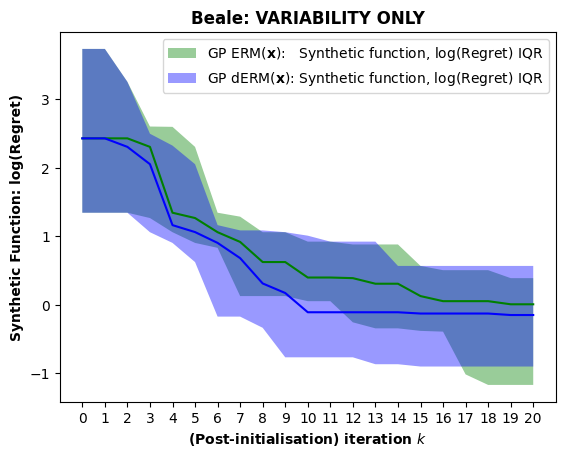

In [163]:
### Visualise!

erm_stddev = ': VARIABILITY ONLY'
title = obj_func + erm_stddev

plt.figure()

plt.plot(median_approx, color = 'Green')
plt.plot(median_exact, color = 'Blue')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Green', alpha=0.4, label='GP ERM($\mathbf{x}$):   Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Blue', alpha=0.4, label='GP dERM($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


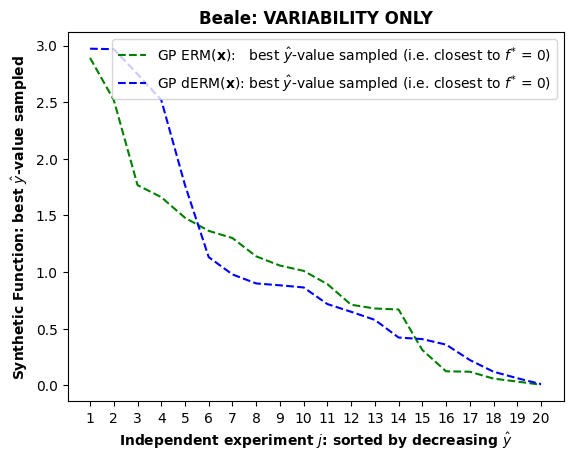

In [164]:
### Visualise!

erm_stddev = ': VARIABILITY ONLY'
title = obj_func + erm_stddev

plt.figure()

plt.plot(np.sort(approx_tau)[::-1], color = 'Green', ls='--', label='GP ERM($\mathbf{x}$):   best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0)')
plt.plot(np.sort(exact_tau)[::-1], color = 'Blue', ls='--', label='GP dERM($\mathbf{x}$): best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0)')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$: sorted by decreasing $\it{\hat{y}}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: best $\it{\hat{y}}$-value sampled', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


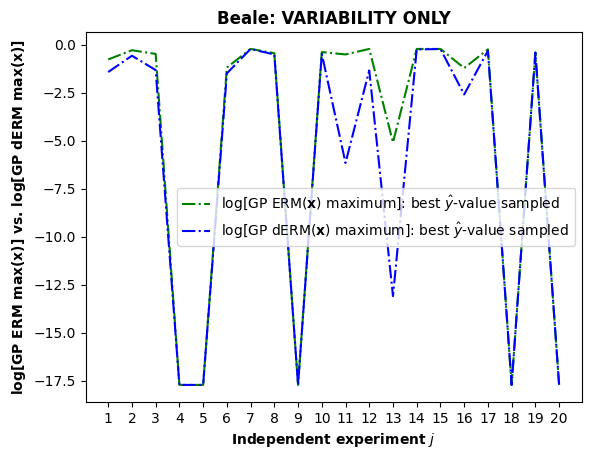

In [165]:
### Visualise!

erm_stddev = ': VARIABILITY ONLY'
title = obj_func + erm_stddev

plt.figure()

plt.plot(np.log(exact_acqFuncApproxBest), color = 'Green', ls='-.', label='log[GP ERM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')
plt.plot(np.log(exact_acqFuncExactBest), color = 'Blue', ls='-.', label='log[GP dERM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('log[GP ERM max($\mathbf{x}$)] vs. log[GP dERM max($\mathbf{x}$)]', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


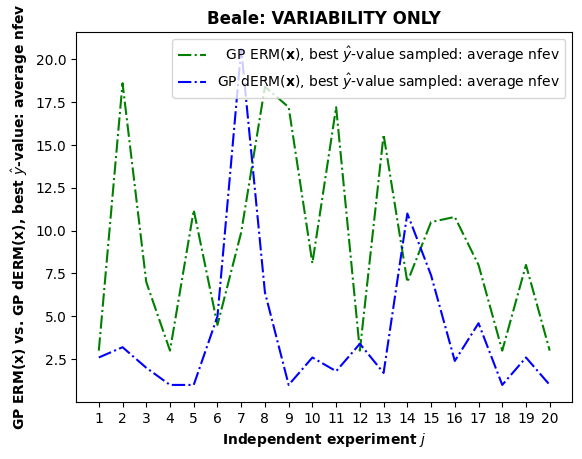

In [166]:
### Visualise!

erm_stddev = ': VARIABILITY ONLY'
title = obj_func + erm_stddev

plt.figure()

plt.plot(approx_nfev_Avg, color = 'Green', ls='-.', label='  GP ERM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')
plt.plot(exact_nfev_Avg, color = 'Blue', ls='-.', label='GP dERM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP ERM($\mathbf{x}$) vs. GP dERM($\mathbf{x}$), best $\it{\hat{y}}$-value: average nfev', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


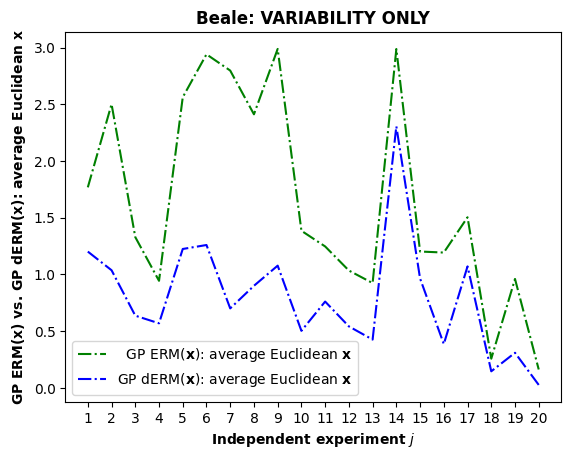

In [167]:
### Visualise!

erm_stddev = ': VARIABILITY ONLY'
title = obj_func + erm_stddev

plt.figure()

plt.plot(approx_euclid_Avg, color = 'Green', ls='-.', label='  GP ERM($\mathbf{x}$): average Euclidean $\mathbf{x}$')
plt.plot(exact_euclid_Avg, color = 'Blue', ls='-.', label='GP dERM($\mathbf{x}$): average Euclidean $\mathbf{x}$')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP ERM($\mathbf{x}$) vs. GP dERM($\mathbf{x}$): average Euclidean $\mathbf{x}$', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


In [168]:
np.round(-approx_4.f_best, 4), np.max(np.round(-approx_4.f_best, 4)), approx_4.best


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 0.0,
 array([-1.26940213, -0.22968993]))

In [169]:
np.round(-approx_4.f_best2, 4), np.max(np.round(-approx_4.f_best2, 4)), approx_4.best2


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 0.0,
 array([-1.26940213, -0.22968993]))

In [170]:
np.round(approx_4.x_best, 4)


array([[-1.211 , -0.2553],
       [-4.3683, -2.832 ],
       [ 0.5022,  1.5938],
       [ 1.3008,  4.028 ],
       [-1.2393,  3.2584],
       [ 2.2579,  1.7829],
       [ 3.094 ,  3.5193],
       [ 1.7737, -3.9383],
       [-2.7917,  0.5702],
       [ 0.4952,  4.2244],
       [ 0.5914,  2.7947],
       [ 1.1803, -3.6823],
       [-1.2694, -0.2297],
       [-3.1738, -0.3069],
       [ 0.7888,  2.6758],
       [ 1.4255,  3.1558],
       [ 3.2391, -3.9201],
       [ 3.8448, -0.6481],
       [ 1.1442, -1.9423],
       [-1.8664, -0.0634]])

In [171]:
np.round(approx_4.x_best2, 4)


array([[-1.211 , -0.2553],
       [-4.3683, -2.832 ],
       [ 0.5022,  1.5938],
       [ 1.3008,  4.028 ],
       [-1.2393,  3.2584],
       [ 2.2579,  1.7829],
       [ 3.094 ,  3.5193],
       [ 1.7737, -3.9383],
       [-2.7917,  0.5702],
       [ 0.4952,  4.2244],
       [ 0.5914,  2.7947],
       [ 1.1803, -3.6823],
       [-1.2694, -0.2297],
       [-3.1738, -0.3069],
       [ 0.7888,  2.6758],
       [ 1.4255,  3.1558],
       [ 3.2391, -3.9201],
       [ 3.8448, -0.6481],
       [ 1.1442, -1.9423],
       [-1.8664, -0.0634]])

In [172]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best)**2))


0.0

In [173]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best2)**2))

0.0